In [1]:
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras import backend as K
import os
import numpy as np
from keras.utils import np_utils
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# matplotlib.rcParams['figure.figsize'] = [10, 10]

Using TensorFlow backend.


In [2]:
FOV_VALS = [30, 40, 50, 60, 70]

PARENT_DIR = '/media/johnkoo/data/stanford-dogs-dataset/'
val_dir = os.path.join(PARENT_DIR, 'val')
test_dir = os.path.join(PARENT_DIR, 'test')

NUM_CLASSES = 120

INPUT_SHAPE = (128, 128, 3)

BATCH_SIZE = 160

RUNS = 8

In [3]:
os.chdir(val_dir)
val_x = np.load('val-images.npy') / 255.
val_y = np.load('val-labels.npy')

os.chdir(test_dir)
test_x = np.load('test-images.npy') / 255.
test_y = np.load('test-labels.npy')

In [4]:
SUBSET_SIZE = 120

dogs = np.unique(val_y)
dogs_subset = np.random.choice(dogs, SUBSET_SIZE, replace=False)

val_ind = np.where(np.isin(val_y, dogs_subset))[0]
test_ind = np.where(np.isin(test_y, dogs_subset))[0]

val_x = val_x[val_ind, :, :, :]
test_x = test_x[test_ind, :, :, :]

val_y = val_y[val_ind]
test_y = test_y[test_ind]

y_dict = dict([(y, x) for x, y in enumerate(sorted(set(val_y)))])

y_val = np.asarray([y_dict[x] for x in val_y])
y_test = np.asarray([y_dict[x] for x in test_y])

y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [5]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [6]:
losses = []
accuracies = []

for fov in FOV_VALS:
    train_dir = os.path.join(PARENT_DIR, 'train', str(fov))
    
    for high_low in ['high', 'low']:
        os.chdir(train_dir)
        if high_low not in os.listdir():
            os.mkdir(high_low)
        train_x = np.load(high_low + '-coverage-images.npy') / 255.
        train_y = np.load(high_low + '-coverage-labels.npy')
        
        train_ind = np.where(np.isin(train_y, dogs_subset))[0]
        train_x = train_x[train_ind, :, :, :]
        train_y = train_y[train_ind]
        
        y_train = np.asarray([y_dict[x] for x in train_y])
        y_train = np_utils.to_categorical(y_train)
        
        os.chdir(high_low)
        
        for i in range(RUNS):
            if str(i) not in os.listdir():
                os.mkdir(str(i))
            
            vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
            model = models.Sequential()
            model.add(vgg_conv)
            model.add(layers.Flatten())
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dense(SUBSET_SIZE, activation='softmax'))
            model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizers.SGD(lr=.001, momentum=.9), 
                          metrics=['acc'])
            
        
            tensorboard = TensorBoard(log_dir=os.path.join(train_dir, high_low, str(i)))
            checkpoint = ModelCheckpoint(os.path.join(train_dir, high_low, str(i)) + '/model-{epoch:04d}.hdf5', 
                                         save_weights_only=False,
                                         save_best_only=False,
                                         mode='auto', 
                                         period=1)
            earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=2)
            
            model.fit(train_x, y_train, 
                      validation_data=(val_x, y_val), 
                      epochs=100, 
                      batch_size=BATCH_SIZE, 
                      verbose=1,
                      shuffle=True, 
                      callbacks=[tensorboard, checkpoint, earlystopping])
            loss, accuracy = model.evaluate(test_x, y_test)
            losses.append(loss)
            accuracies.append(accuracy)
            
            K.clear_session()
            del model
            gc.collect()

Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 36s 6ms/step - loss: 4.7997 - acc: 0.0130 - val_loss: 4.7873 - val_acc: 0.0127
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.5639 - acc: 0.0418 - val_loss: 4.8468 - val_acc: 0.0177
Epoch 3/100
4222/4222 [==============================] - 8s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8112 - acc: 0.0112 - val_loss: 4.7862 - val_acc: 0.0097
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.6337 - acc: 0.0372 - val_loss: 4.8225 - val_acc: 0.0157
Epoch 3/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8146 - acc: 0.0090 - val_loss: 4.7873 - val_acc: 0.0120
Epoch 2/100
6000/6000 [===============

4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8184 - acc: 0.0085 - val_loss: 4.7747 - val_acc: 0.0157
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.6802 - acc: 0.0282 - val_loss: 4.7159 - val_acc: 0.0193
Epoch 3/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.3140 - acc: 0.0675 - val_loss: 4.6669 - val_acc: 0.0313
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.6144 - acc: 0.1543 - val_loss: 4.5023 - val_acc: 0.0643
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.9855 - acc: 0.2663 - val_loss: 4.5142 - val_acc: 0.0693
Epoch 6/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8209 - acc: 0.0100

6000/6000 [==============================] - 29s 5ms/step - loss: 3.8372 - acc: 0.1265 - val_loss: 4.7358 - val_acc: 0.0343
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.9352 - acc: 0.2743 - val_loss: 4.7540 - val_acc: 0.0453
Epoch 5/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8091 - acc: 0.0093 - val_loss: 4.7776 - val_acc: 0.0103
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.5871 - acc: 0.0388 - val_loss: 4.7034 - val_acc: 0.0217
Epoch 3/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.9688 - acc: 0.1023 - val_loss: 4.7690 - val_acc: 0.0293
Epoch 4/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8031 - acc: 0.0128

6000/6000 [==============================] - 28s 5ms/step - loss: 1.0592 - acc: 0.7075 - val_loss: 4.2670 - val_acc: 0.1637
Epoch 8/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8127 - acc: 0.0092 - val_loss: 4.7682 - val_acc: 0.0170
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.6154 - acc: 0.0352 - val_loss: 4.6316 - val_acc: 0.0300
Epoch 3/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.0593 - acc: 0.0972 - val_loss: 4.3716 - val_acc: 0.0617
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.2784 - acc: 0.2263 - val_loss: 3.9656 - val_acc: 0.1097
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.4515 - acc: 0.3723 - val_loss: 3.8951 - val_acc: 0.1410
Epoch 6/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1

6000/6000 [==============================] - 29s 5ms/step - loss: 2.2180 - acc: 0.4162 - val_loss: 4.3046 - val_acc: 0.1027
Epoch 6/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8151 - acc: 0.0088 - val_loss: 4.7718 - val_acc: 0.0107
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.5773 - acc: 0.0428 - val_loss: 4.6162 - val_acc: 0.0297
Epoch 3/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.8218 - acc: 0.1327 - val_loss: 4.4099 - val_acc: 0.0637
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.8230 - acc: 0.3007 - val_loss: 4.1226 - val_acc: 0.0963
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1.9921 - acc: 0.4720 - val_loss: 4.1025 - val_acc: 0.1260
Epoch 6/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1

6000/6000 [==============================] - 29s 5ms/step - loss: 4.3440 - acc: 0.0725 - val_loss: 4.4046 - val_acc: 0.0540
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.6379 - acc: 0.1683 - val_loss: 4.0030 - val_acc: 0.1003
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.8190 - acc: 0.3108 - val_loss: 3.8291 - val_acc: 0.1380
Epoch 6/100
6000/6000 [==============================] - 28s 5ms/step - loss: 1.9830 - acc: 0.4865 - val_loss: 3.7863 - val_acc: 0.1577
Epoch 7/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1.3192 - acc: 0.6430 - val_loss: 3.9611 - val_acc: 0.1730
Epoch 8/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8311 - acc: 0.0090 - val_loss: 4.7809 - val_acc: 0.0133
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4

4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8187 - acc: 0.0100 - val_loss: 4.7641 - val_acc: 0.0077
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.6115 - acc: 0.0387 - val_loss: 4.5671 - val_acc: 0.0387
Epoch 3/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.8851 - acc: 0.1238 - val_loss: 4.1693 - val_acc: 0.1070
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.6292 - acc: 0.3275 - val_loss: 3.7764 - val_acc: 0.1537
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1.7489 - acc: 0.5258 - val_loss: 3.6446 - val_acc: 0.1847
Epoch 6/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1.0587 - acc: 0.6957 - val_loss: 3.9579 - val_acc: 0.2087
Epoch 7/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6

6000/6000 [==============================] - 29s 5ms/step - loss: 4.7184 - acc: 0.0253 - val_loss: 4.6891 - val_acc: 0.0273
Epoch 3/100
6000/6000 [==============================] - 30s 5ms/step - loss: 4.4332 - acc: 0.0680 - val_loss: 4.3616 - val_acc: 0.0710
Epoch 4/100
6000/6000 [==============================] - 30s 5ms/step - loss: 3.6459 - acc: 0.1697 - val_loss: 3.8454 - val_acc: 0.1260
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/step - loss: 2.7804 - acc: 0.3140 - val_loss: 3.7836 - val_acc: 0.1533
Epoch 6/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1.9510 - acc: 0.5017 - val_loss: 3.6993 - val_acc: 0.1800
Epoch 7/100
6000/6000 [==============================] - 29s 5ms/step - loss: 1.3015 - acc: 0.6528 - val_loss: 4.0702 - val_acc: 0.1910
Epoch 8/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 30s 5ms/step - loss: 4

Epoch 4/100
6000/6000 [==============================] - 30s 5ms/step - loss: 2.3230 - acc: 0.3900 - val_loss: 3.3252 - val_acc: 0.2173
Epoch 5/100
6000/6000 [==============================] - 30s 5ms/step - loss: 1.5325 - acc: 0.5790 - val_loss: 3.4949 - val_acc: 0.2277
Epoch 6/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8182 - acc: 0.0078 - val_loss: 4.7697 - val_acc: 0.0173
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.6977 - acc: 0.0310 - val_loss: 4.6778 - val_acc: 0.0313
Epoch 3/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.2433 - acc: 0.0863 - val_loss: 4.2340 - val_acc: 0.0870
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.2543 - acc: 0.2313 - val_loss: 3.8414 - val_acc: 0.1237
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/st

6000/6000 [==============================] - 30s 5ms/step - loss: 4.7287 - acc: 0.0223 - val_loss: 4.6963 - val_acc: 0.0317
Epoch 3/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.4940 - acc: 0.0592 - val_loss: 4.4069 - val_acc: 0.0593
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/step - loss: 3.8325 - acc: 0.1422 - val_loss: 4.0558 - val_acc: 0.1123
Epoch 5/100
6000/6000 [==============================] - 30s 5ms/step - loss: 2.9943 - acc: 0.2735 - val_loss: 3.7619 - val_acc: 0.1477
Epoch 6/100
6000/6000 [==============================] - 30s 5ms/step - loss: 2.2472 - acc: 0.4265 - val_loss: 3.7977 - val_acc: 0.1760
Epoch 7/100
4222/4222 [==============================] - 7s 2ms/step
Train on 6000 samples, validate on 3000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4.8208 - acc: 0.0073 - val_loss: 4.7696 - val_acc: 0.0160
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/step - loss: 4

In [7]:
fov_vals = np.repeat(FOV_VALS, [int(i) for i in np.ones(len(FOV_VALS)) * 2 * RUNS])

In [12]:
# highlow = np.tile(['high', 'high', 'high', 'high', 'low', 'low', 'low', 'low'], len(FOV_VALS))
highlow = np.tile(np.concatenate([np.repeat('high', RUNS), 
                                  np.repeat('low', RUNS)]), 
                  len(FOV_VALS))

In [17]:
results_df = pd.DataFrame({'fov': fov_vals, 
                           'size': highlow, 
                           'loss': losses, 
                           'accuracy': accuracies})
results_df.to_csv('/media/johnkoo/data/stanford-dogs-dataset/results-size.csv')

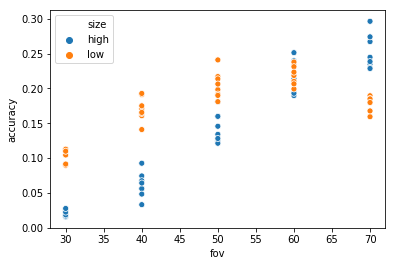

In [18]:
sns.scatterplot(x='fov', y='accuracy', hue='size', data=results_df)

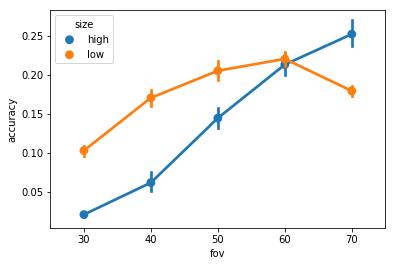

In [19]:
sns.pointplot(x='fov', y='accuracy', hue='size', data=results_df)

In [20]:
results_df.shape

(80, 4)

In [21]:
results_df

,fov,size,loss,accuracy
0,30,high,5.003292,0.023449
1,30,high,5.036950,0.016106
2,30,high,5.079213,0.015632
3,30,high,5.006257,0.016817
4,30,high,4.907089,0.024870
5,30,high,4.975314,0.018475
6,30,high,5.344935,0.022501
7,30,high,4.890185,0.027712
8,30,low,5.341550,0.112743
9,30,low,4.407068,0.104453
